In [ ]:
from google.colab import files

files.upload()

{}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
inputs = pd.read_pickle("/content/Sampled_inputs3.pck")
labels = pd.read_pickle("/content/Sampled_labels3.pck")

In [ ]:
inputs.shape

(3600, 60, 33)

In [ ]:
inputs = inputs.transpose(0,2,1)
inputs.shape

(3600, 33, 60)

In [ ]:
from collections import Counter
label_count = Counter(labels)
label_count

Counter({0: 600, 1: 1200, 2: 600, 3: 600, 4: 600})

In [ ]:
len(labels)

3600

In [ ]:
labels = np.where(labels == 0, 1, labels)
labels = np.where(((labels == 2)|(labels ==3)|(labels ==4)), 0, labels)
print(labels)

[1 1 1 ... 0 0 0]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=42)

In [ ]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

In [ ]:
from collections import Counter

In [ ]:
recounted = Counter(y_train)
recounted

Counter({0: 1375, 1: 1325})

In [ ]:
recounted = Counter(y_test)
recounted

Counter({0: 425, 1: 475})

In [ ]:
X_train.shape

(2700, 33, 60)

In [ ]:
X_test.shape

(900, 33, 60)

In [ ]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=0, min_delta=1e-4, mode='min')

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

input = Input(shape=(33, 60))
x = Permute((2, 1))(input)
x = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


x = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


x = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling1D()(x)

out = Dense(1, activation='sigmoid')(x)

model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33, 60)]          0         
_________________________________________________________________
permute (Permute)            (None, 60, 33)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           33920     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 60, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 256)           164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 256)           1024  

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=80, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1,)

Epoch 1/80
19/19 [==============================] - 10s 487ms/step - loss: 0.5419 - accuracy: 0.7246 - val_loss: 0.6868 - val_accuracy: 0.5222
Epoch 2/80
19/19 [==============================] - 9s 457ms/step - loss: 0.4315 - accuracy: 0.7765 - val_loss: 0.6513 - val_accuracy: 0.5333
Epoch 3/80
19/19 [==============================] - 9s 452ms/step - loss: 0.4125 - accuracy: 0.8080 - val_loss: 0.6266 - val_accuracy: 0.6778
Epoch 4/80
19/19 [==============================] - 9s 459ms/step - loss: 0.4131 - accuracy: 0.7983 - val_loss: 0.5781 - val_accuracy: 0.6889
Epoch 5/80
19/19 [==============================] - 8s 446ms/step - loss: 0.4000 - accuracy: 0.7958 - val_loss: 0.4990 - val_accuracy: 0.7741
Epoch 6/80
19/19 [==============================] - 8s 441ms/step - loss: 0.3936 - accuracy: 0.8100 - val_loss: 0.4817 - val_accuracy: 0.7815
Epoch 7/80
19/19 [==============================] - 8s 445ms/step - loss: 0.3916 - accuracy: 0.8072 - val_loss: 0.4310 - val_accuracy: 0.7963
Epoch

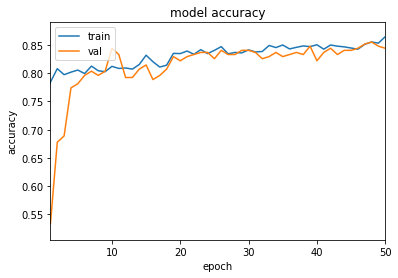

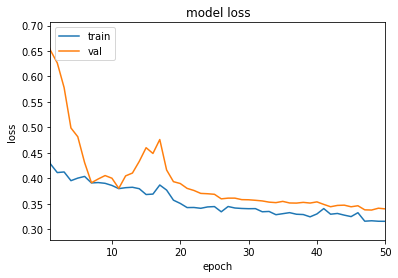

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim(1, 50)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(1, 50)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predict = (model.predict(X_test) > 0.5).astype('int32')

In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, y_predict).ravel()
tss = (TP / (TP + FN)) - (FP / (FP + TN))
print("tss: ",tss)

tss:  0.7154179566563468


In [ ]:
target_names =  ['class 0', 'class 1']
print(classification_report(y_test, y_predict, target_names=target_names, digits = 4))

              precision    recall  f1-score   support

     class 0     0.8785    0.8165    0.8463       425
     class 1     0.8455    0.8989    0.8714       475

    accuracy                         0.8600       900
   macro avg     0.8620    0.8577    0.8589       900
weighted avg     0.8611    0.8600    0.8596       900



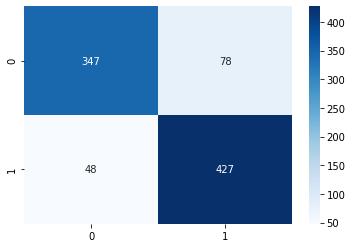

In [ ]:
cm = confusion_matrix(y_test, y_predict)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d")

In [ ]:
def squeeze_excite_block(input):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    filters = input.shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

input = Input(shape=(33, 60))
x = Masking()(input)
x = LSTM(8)(x)
x = Dropout(0.8)(x)

y = Permute((2, 1))(input)
y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = squeeze_excite_block(y)


y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = squeeze_excite_block(y)


y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)


y = GlobalAveragePooling1D()(y)
x = concatenate([x, y])

out = Dense(1, activation='sigmoid')(x)

model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33, 60)]     0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 60, 33)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 60, 128)      33920       permute_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 60, 128)      512         conv1d_3[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=80, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1,)

Epoch 1/80
19/19 [==============================] - 15s 551ms/step - loss: 0.5621 - accuracy: 0.6688 - val_loss: 0.6211 - val_accuracy: 0.5259
Epoch 2/80
19/19 [==============================] - 9s 469ms/step - loss: 0.4239 - accuracy: 0.7824 - val_loss: 0.6001 - val_accuracy: 0.5704
Epoch 3/80
19/19 [==============================] - 9s 464ms/step - loss: 0.4109 - accuracy: 0.7925 - val_loss: 0.5868 - val_accuracy: 0.7333
Epoch 4/80
19/19 [==============================] - 9s 460ms/step - loss: 0.3963 - accuracy: 0.7903 - val_loss: 0.5420 - val_accuracy: 0.7852
Epoch 5/80
19/19 [==============================] - 9s 451ms/step - loss: 0.3980 - accuracy: 0.7956 - val_loss: 0.4833 - val_accuracy: 0.8000
Epoch 6/80
19/19 [==============================] - 9s 461ms/step - loss: 0.3863 - accuracy: 0.8042 - val_loss: 0.4509 - val_accuracy: 0.8000
Epoch 7/80
19/19 [==============================] - 9s 469ms/step - loss: 0.3917 - accuracy: 0.8221 - val_loss: 0.4218 - val_accuracy: 0.8111
Epoch

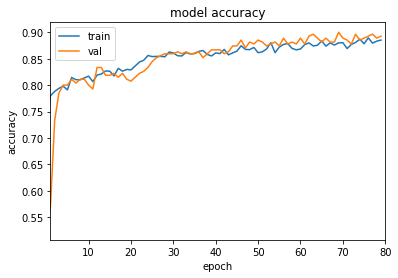

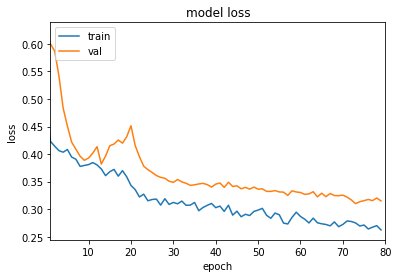

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim(1, 80)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(1, 80)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predict = (model.predict(X_test) > 0.5).astype('int32')

In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, y_predict).ravel()
tss = (TP / (TP + FN)) - (FP / (FP + TN))
print("tss: ",tss)

tss:  0.7074922600619196


In [ ]:
from sklearn.metrics import classification_report
target_names =  ['class 0', 'class 1']
print(classification_report(y_test, y_predict, target_names=target_names, digits = 4))

              precision    recall  f1-score   support

     class 0     0.9046    0.7812    0.8384       425
     class 1     0.8255    0.9263    0.8730       475

    accuracy                         0.8578       900
   macro avg     0.8651    0.8537    0.8557       900
weighted avg     0.8629    0.8578    0.8567       900



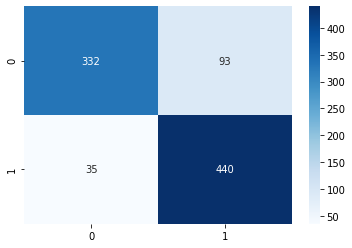

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_predict)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d")